In [23]:
%matplotlib inline

In [24]:
import pandas as pd
import numpy as np
from scipy.stats import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nb
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

In [25]:
df_kim = pd.read_csv("/home/julia/workspace/rodent_gradients/interneurons.csv", header=1)

In [26]:
mcc = MouseConnectivityCache(manifest_file=
                             '/home/julia/data/gradients/atlas/allen_api/mouse_connectivity_manifest.json')
structure_tree = mcc.get_structure_tree()
iso_structs = structure_tree.descendants([315])[0]

### Make a dataframe with only the layer 2/3 structures

In [49]:
l2_3 = []
for i in range(len(iso_structs)):
    if 'layer 2/3' in iso_structs[i]['name'].lower():
        l2_3.append(iso_structs[i])
    elif 'layer 2' in iso_structs[i]['name'].lower():
        l2_3.append(iso_structs[i])
    elif 'layer 1' in iso_structs[i]['name'].lower():
        l2_3.append(iso_structs[i])
df2_3 = pd.DataFrame()
for r in l2_3:
    df2_3 = df2_3.append(df_kim.loc[df_kim['ROI'] == r['acronym']], ignore_index=True)
    
df2_3['id']=np.nan
for r in l2_3:
    df2_3.loc[df2_3['ROI']==r['acronym'],'id'] = r['id']

In [50]:
df2_3['g0'] = np.nan
df2_3['g1'] = np.nan
df2_3['g2'] = np.nan
df2_3['g3'] = np.nan
df2_3['g4'] = np.nan
df2_3['g5'] = np.nan

In [51]:
img = nb.load("/home/julia/data/gradients/atlas/allen_api/annotation/annotation_200um.nii.gz")
annot = img.get_data()
gradients = nb.load('/home/julia/data/gradients/results/embedding_vol/embed.nii.gz').get_data()

In [52]:
for idx in df2_3['id']:
    for g in range(6):
        df2_3.loc[df2_3['id']==idx, 'g%s' %str(g)] = np.nanmean(gradients[:,:,:,g][annot==idx])

/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [53]:
df2_3 = df2_3.dropna(axis=0)
df2_3 = df2_3.drop(columns=['Full name', 'structureOrder', 'standard deviation', 'standard deviation.1',
                           'standard deviation.2', 'standard deviation.3', 'standard deviation.4', 
                            'standard deviation.5', 'standard deviation.6', 'Average.3', 'Average.4',
                           'Average.5', 'Average.6'])

In [54]:
df2_3 = df2_3.rename(columns={"Average": "PV avg", "Average.1": "SST avg",  "Average.2": "VIP avg"})

In [55]:
for a in df2_3["ROI"]:
    df2_3.loc[df2_3["ROI"]==a, "PV avg"] = int(df2_3[df2_3["ROI"]==a]['PV avg'].values[0].replace(u'\xa0', u''))
    df2_3.loc[df2_3["ROI"]==a, "SST avg"] = int(df2_3[df2_3["ROI"]==a]['SST avg'].values[0].replace(u'\xa0', u''))
    df2_3.loc[df2_3["ROI"]==a, "VIP avg"] = int(df2_3[df2_3["ROI"]==a]['VIP avg'].values[0].replace(u'\xa0', u''))

In [56]:
df2_3["PV/SST"] = df2_3['PV avg'] / (df2_3['PV avg']+df2_3['SST avg'])

In [57]:
df2_3.to_csv("/home/julia/data/gradients/atlas/interneurons/supragranular_regions.csv")

In [59]:
for g in range(6):
    for c in ['PV avg', 'SST avg', 'VIP avg', 'PV/SST']:
        r = stats.spearmanr(df2_3['g%i' %g], df2_3[c])
        if r[1]<0.01:
            print('Gradient %i, %s:' %(g,c), r)

Gradient 2, PV avg: SpearmanrResult(correlation=0.34622847039058052, pvalue=0.0025134671680427188)
Gradient 2, VIP avg: SpearmanrResult(correlation=0.33168456127360235, pvalue=0.0038907443342035444)
Gradient 2, PV/SST: SpearmanrResult(correlation=0.36494631617919282, pvalue=0.0013887752074441988)


### Plotting

In [41]:
df_plotting = pd.read_csv('/home/julia/workspace/rodent_gradients/finest_regions.csv')

In [42]:
df2_3['cluster'] = np.nan

In [43]:
for a in df2_3["ROI"]:
    df2_3.loc[df2_3['ROI']==a, 'cluster'] = df_plotting.loc[df_plotting['acronym']==a[:-3], 'cluster'].values[0]

In [44]:
df2_3.loc[df2_3['ROI']=='MOp2/3', 'cluster'] = 'motor'
df2_3.loc[df2_3['ROI']=='MOs2/3', 'cluster'] = 'motor'
df2_3.loc[df2_3['cluster']=='somatomotor', 'cluster'] = 'somatosensory'

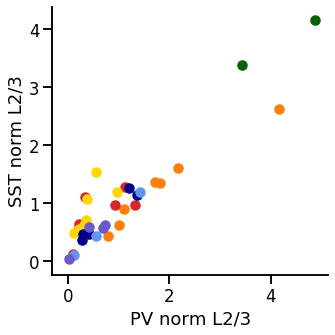

In [45]:
clusters = ['motor', 'somatosensory', 'prefrontal','lateral', 'medial', 'visual', 'auditory']
colors = ['darkgreen', 'tab:orange', 'tab:red', 'gold', 'darkblue','cornflowerblue','slateblue']
sns.set_context('talk')
fig = plt.figure(figsize=(5,5))

pv_norm = np.mean(df2_3['PV avg'])
sst_norm = np.mean(df2_3['SST avg'])

for c in range(len(clusters)):
    regions = list(df2_3.loc[df2_3['cluster']==clusters[c], "ROI"])
    for r in regions:
        plt.scatter(df2_3.loc[df2_3['ROI']==r, 'PV avg'].values[0] / pv_norm, 
                    df2_3.loc[df2_3['ROI']==r, 'SST avg'].values[0] / sst_norm, 
                    color=colors[c], label=clusters[c])
plt.xlabel('PV norm L2/3')
plt.ylabel('SST norm L2/3')
plt.tight_layout()
sns.despine()

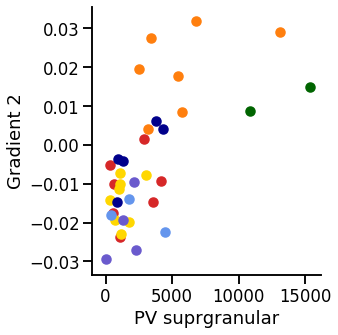

In [46]:
clusters = ['motor', 'somatosensory', 'prefrontal','lateral', 'medial', 'visual', 'auditory']
colors = ['darkgreen', 'tab:orange', 'tab:red', 'gold', 'darkblue','cornflowerblue','slateblue']
sns.set_context('talk')
fig = plt.figure(figsize=(5,5))

for c in range(len(clusters)):
    regions = list(df2_3.loc[df2_3['cluster']==clusters[c], "ROI"])
    for r in regions:
        plt.scatter(df2_3.loc[df2_3['ROI']==r, 'PV avg'].values[0] , 
                    df2_3.loc[df2_3['ROI']==r, 'g2'].values[0], 
                    color=colors[c], label=clusters[c])
plt.xlabel('PV suprgranular')
plt.ylabel('Gradient 2')
plt.tight_layout()
sns.despine()

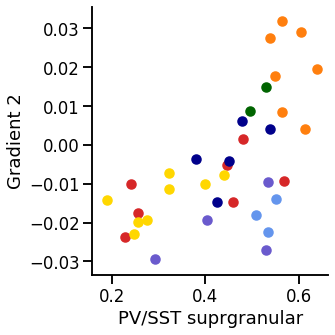

In [48]:
clusters = ['motor', 'somatosensory', 'prefrontal','lateral', 'medial', 'visual', 'auditory']
colors = ['darkgreen', 'tab:orange', 'tab:red', 'gold', 'darkblue','cornflowerblue','slateblue']
sns.set_context('talk')
fig = plt.figure(figsize=(5,5))

for c in range(len(clusters)):
    regions = list(df2_3.loc[df2_3['cluster']==clusters[c], "ROI"])
    for r in regions:
        plt.scatter(df2_3.loc[df2_3['ROI']==r, 'PV/SST'].values[0] , 
                    df2_3.loc[df2_3['ROI']==r, 'g2'].values[0], 
                    color=colors[c], label=clusters[c])
plt.xlabel('PV/SST suprgranular')
plt.ylabel('Gradient 2')
plt.tight_layout()
sns.despine()